# Google Quest QA Labeling

## 1. Data retrieval

### 1.1. Import modules

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from matplotlib_venn import venn2


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelBinarizer

import json
import requests
import sys

# import tensorflow_hub as hub
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm

from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from sklearn.linear_model import MultiTaskElasticNet
import tensorflow as tf
import torch
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import LSTM, Input, Dense, Dropout


%matplotlib inline

In [27]:
class Analysis(object):
    '''
    Store code which is referenced by agent.ipynb.

    It helps to get rid of redundant code in jupyter notebook, and
    also makes it more cleaner.
    '''

    def host_distribution(self, distribution, title):
        fig = px.pie(names=distribution.index, 
             values=distribution.values, 
             title=title,
             width=800, 
             height=800)

        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.update_layout(showlegend=True)
        fig.show()
        
    def categories_distribution(self, categories, title):
        
        category_share = pd.DataFrame({'share': categories.value_counts() / categories.count()})
        category_share['category'] = category_share.index   
        
        fig = px.bar(category_share, x='category', y='share',
            labels={'share':'share in %'},
            title=title)
        
        fig.show()
    
    def venn_diagrams(self, columns, plot_num, title):
        plt.subplot(plot_num)
        venn2([set(columns[0].unique()), set(columns[1].unique())], set_labels = ('Train set', 'Test set'))
        plt.title(title)
        plt.show()
    
    def distribution_imposition(self, first_col, second_col, title):
        plt.figure(figsize=(20, 6))
        sns.distplot(first_col.str.len())
        sns.distplot(second_col.str.len())
        plt.title(title)
        plt.show()

class Feature_Engineering(object):
    '''
    Helper class used for Feature engineering purposes.
    
    '''
    def __init__(self, dataframe):
        self.dataframe = dataframe
        with open("../input/charset/charset.json", encoding="utf8") as json_file:
            self.charset  = json.load(json_file)
        
        self.vectorizer = TfidfVectorizer(ngram_range=(1, 3))
        self.tsvd = TruncatedSVD(n_components = 128, n_iter=5)
        
#         sys.path.insert(0, "../input/transformers/transformers-master/")
        self.tokenizer = DistilBertTokenizer.from_pretrained('../input/distilbert-base-uncased/') # '../input/distilbertbaseuncased/'
        self.model = DistilBertModel.from_pretrained('../input/distilbert-base-uncased/')
        
        self.binarizer = LabelBinarizer()


    def unconstrained_chars(self, column, index):
        df = self.dataframe[column][index]
        for char in self.charset['CHARS']:
            df = df.replace(char, '')
        return df

    def shortcuts_removal(self, column, index):
        return ' '.join(list(map(lambda word: self.find_and_replace(word), self.dataframe[column][index].split())))
        
    def lower_case(self, column):
        return self.dataframe[column].str.lower()
        
    
    def find_and_replace(self, word):
        for key, value in self.charset['SHORTCUTS'].items():
            if key == word:
                return value
        return word

    def flow(self, column):
        self.dataframe[column] = self.lower_case(column)
        for index in range(self.dataframe[column].shape[0]):
            self.dataframe[column][index] = self.unconstrained_chars(column, index)
            self.dataframe[column][index] = self.shortcuts_removal(column, index)

        return self.dataframe[column]
    
    def tfidf_vec(self, column):
        return list(self.tsvd.fit_transform(self.vectorizer.fit_transform(self.dataframe[column].values)))
    
    def binarize(self, column, other_df):
        if len(self.dataframe[column].value_counts()) < len(other_df[column].value_counts()):
            diff = abs(len(self.dataframe[column].value_counts()) - len(other_df[column].value_counts()))
            return list(np.concatenate([list(self.binarizer.fit_transform(self.dataframe[column].values)), np.zeros((self.dataframe.shape[0], diff))], axis=1))
        return list(self.binarizer.fit_transform(self.dataframe[column].values))
    
    def bert_separators(self, column):
        for index in range(self.dataframe[column].shape[0]):
            self.dataframe[column][index] = self.dataframe[column][index].split('.')
            
        return self.dataframe[column]
    
    def model_conf(self):
        self.model.cpu()
        
    def make_vectors(self, column):
        ids = self.dataframe[column].str.slice(0, 500).apply(self.tokenizer.encode)
        vectors = []

        for column in tqdm(ids):
            input_ids = torch.Tensor(column).to(torch.int64).unsqueeze(0)
            try:
                outputs = self.model(input_ids.cpu())
                vectors.append(outputs[0].detach().cpu().numpy().max(axis = 1))

            except:
                vectors.append(np.zeros(outputs[0].detach().cpu().numpy().max(axis = 1)).shape)
        
        return vectors

class SpearmanCallback(Callback):
    '''
    --TO REFACTOR--
    
    Class for calculating and displaing Spearman Rho value
    as a callback after each epoch.
    '''
    def __init__(self, validation_data, model_name):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs={}):
        y_pred_val = self.model.predict(self.x_val)
        rho_val = np.mean([spearmanr(np.array(self.y_val)[:, 0, ind], np.array(y_pred_val)[:, 0, ind]).correlation for ind in range(y_pred_val.shape[1])])
        
        #self.model.save_weights(self.model_name)
        print('validation rho spearman callback value: {}'.format(rho_val))
        return rho_val

class Network(object):
    '''
    --TO REFACTOR--
    Neural network architecture class
    
    Model consist in LSTM blocks with dense neural network 
    with data divided by cross validation.
    '''
    
    def create_model():
        inps = Input(shape=(1, X_train.shape[1]))
        x = LSTM(128, dropout=0.2, return_sequences=True)(inps)
        x = Dense(512, activation='elu')(inps)
        x = Dropout(0.2)(x)
        y = Dense(Y_train.shape[1], activation='sigmoid')(x)
        model = Model(inputs=inps, outputs=y)

    #     print(X_train.shape)    
    #     tmp = X_train.reshape(-1, 1, 10085)    
    #     print(tmp.shape)
    #     model = Sequential()
    # #     model.add(LSTM(128, return_sequences=True, dropout=0.2, input_shape=(1, X_train.shape[1]))) #check out stateful=True, 
    #     model.add(Dense(512, activation='elu'))
    #     model.add(Dropout(0.2))
    #     model.add(Dense(Y_train.shape[1], activation='sigmoid'))
        model.compile(
            optimizer=Adam(), # to check
            loss=['mean_squared_error']
        )
        model.summary()
        return model

### 1.2. Reading Data

In [3]:
train_set = pd.read_csv('../input/google-quest-challenge/train.csv')
X_test = pd.read_csv('../input/google-quest-challenge/test.csv')
sample_submission = pd.read_csv('../input/google-quest-challenge/sample_submission.csv')
X_test

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com
...,...,...,...,...,...,...,...,...,...,...,...
471,9569,change gb4e enumeration in only one chapter,I am using gb4e for glossing examples in my th...,ToddAO,https://tex.stackexchange.com/users/28332,You can simply reset the exx counter just afte...,karlkoeller,https://tex.stackexchange.com/users/27635,http://tex.stackexchange.com/questions/165120/...,TECHNOLOGY,tex.stackexchange.com
472,9590,All anagrams in a File,Source : Microsoft Interview Question\n\nWe ar...,Spandan,https://stackoverflow.com/users/2426101,Slightly different approach from the one above...,Algorithmatic,https://stackoverflow.com/users/1122229,http://stackoverflow.com/questions/16872513/al...,STACKOVERFLOW,stackoverflow.com
473,9597,SQL Server: Time Series Table Design,I am creating a time series database that foll...,Jay Michael,https://dba.stackexchange.com/users/47001,A foreign key can reference a unique constrain...,mustaccio,https://dba.stackexchange.com/users/23721,http://dba.stackexchange.com/questions/105287/...,TECHNOLOGY,dba.stackexchange.com
474,9623,Is a countered flashback spell exiled?,If I flashback Past in Flames and it is counte...,BolasStone,https://boardgames.stackexchange.com/users/9981,If you counter a spell cast for its Flashback ...,murgatroid99,https://boardgames.stackexchange.com/users/2537,http://boardgames.stackexchange.com/questions/...,CULTURE,boardgames.stackexchange.com


In [4]:
train_set = np.split(train_set, [train_set.columns.get_loc('question_asker_intent_understanding')], axis=1)
X_train = train_set[0]
X_train

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com
...,...,...,...,...,...,...,...,...,...,...,...
6074,9642,Using a ski helmet for winter biking,I am curious if anyone uses a skiing helmet fo...,sixtyfootersdude,https://bicycles.stackexchange.com/users/134,If you're thinking about wearing a ski helmet ...,Matt Leo,https://bicycles.stackexchange.com/users/3340,http://bicycles.stackexchange.com/questions/99...,CULTURE,bicycles.stackexchange.com
6075,9643,Adjustment to road bike brakes for high grade ...,I have a road bike with a front brake that wea...,ash,https://bicycles.stackexchange.com/users/14519,\nYou can replace the pads (as stated elsewher...,Daniel R Hicks,https://bicycles.stackexchange.com/users/1584,http://bicycles.stackexchange.com/questions/25...,CULTURE,bicycles.stackexchange.com
6076,9645,Suppress 'file truncated' messages when using ...,I'm tailing a log file using tail -f messages....,Maneating Koala,https://unix.stackexchange.com/users/60445,Maybe help if can be fixes origin of this erro...,BG Bruno,https://unix.stackexchange.com/users/68208,http://unix.stackexchange.com/questions/169054...,TECHNOLOGY,unix.stackexchange.com
6077,9646,When should a supervisor be a co-author?,What are people's views on this? To be specif...,MrB,https://mathoverflow.net/users/2189,"As a non-mathematician, I am somewhat mystifie...",angela,https://mathoverflow.net/users/4267,http://mathoverflow.net/questions/57337,SCIENCE,mathoverflow.net


In [5]:
Y_train = pd.concat([X_train['qa_id'], train_set[1]], axis=1)
Y_train

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,1,0.333333,0,0,0,0,1,1,0,...,1,1,0.666667,1,1,0.8,1,0,0,1
1,1,1,1,0,0.5,1,1,0.444444,0.444444,0.666667,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0,0,0.666667,0.888889
2,2,0.888889,0.666667,0,1,1,1,0.666667,0.444444,0.333333,...,0.777778,0.777778,0.555556,1,1,0.666667,0,0.333333,1,0.888889
3,3,0.888889,0.666667,0.666667,1,1,1,0.444444,0.444444,0,...,0.888889,0.833333,0.333333,0.833333,1,0.8,0,0,1,1
4,5,1,0.666667,0,1,1,1,0.666667,0.666667,0,...,1,1,0.666667,1,1,0.8,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,9642,1,0.777778,0,1,1,1,0.888889,0.888889,0.333333,...,0.777778,1,0.555556,1,1,0.866667,0,0,0,0.888889
6075,9643,1,0.777778,0,1,0.666667,0.5,0.777778,0.777778,0,...,0.777778,0.888889,0.555556,1,1,0.733333,0.666667,0.333333,0,0.888889
6076,9645,0.888889,0.555556,0,0.666667,0.333333,1,0.444444,0.333333,0,...,0.444444,0.888889,0.555556,0.888889,0.888889,0.8,1,0,0.333333,0.555556
6077,9646,1,0.444444,0.333333,0,0,0,0.777778,0.555556,1,...,1,0.888889,0.555556,1,1,0.533333,0,0.333333,0.666667,1


## 2. Exploratory Data analysis

In [6]:
analysis = Analysis()

### 2.1. Data Description

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 11 columns):
qa_id                 6079 non-null object
question_title        6079 non-null object
question_body         6079 non-null object
question_user_name    6079 non-null object
question_user_page    6079 non-null object
answer                6079 non-null object
answer_user_name      6079 non-null object
answer_user_page      6079 non-null object
url                   6079 non-null object
category              6079 non-null object
host                  6079 non-null object
dtypes: object(11)
memory usage: 522.5+ KB


In [8]:
X_train.describe()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
count,6079,6079,6079,6079,6079,6079,6079,6079,6079,6079,6079
unique,6079,3583,3583,3215,3422,6079,4114,4430,3583,5,63
top,9081,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Mike,https://stats.stackexchange.com/users/5,"I worked on VWs and Audis for a while, we had ...",Scott,https://tex.stackexchange.com/users/4427,http://stats.stackexchange.com/questions/125/w...,TECHNOLOGY,stackoverflow.com
freq,1,12,12,15,12,1,20,17,12,2441,1253


In [9]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 11 columns):
qa_id                 476 non-null int64
question_title        476 non-null object
question_body         476 non-null object
question_user_name    476 non-null object
question_user_page    476 non-null object
answer                476 non-null object
answer_user_name      476 non-null object
answer_user_page      476 non-null object
url                   476 non-null object
category              476 non-null object
host                  476 non-null object
dtypes: int64(1), object(10)
memory usage: 41.0+ KB


In [10]:
X_test.describe()

,qa_id
count,476.000000
mean,5029.186975
std,2812.670060
min,39.000000
25%,2572.000000
50%,5093.000000
75%,7482.000000
max,9640.000000


In [11]:
print('Size of X_train', X_train.shape)
print('Size of Y_train', Y_train.shape)
print('Size of X_test', X_test.shape)

Size of X_train (6079, 11)
Size of Y_train (6079, 31)
Size of X_test (476, 11)


### 2.2. Host distribution visualization

In [12]:
X_train_host_dist = X_train["host"].value_counts()
X_test_host_dist = X_test["host"].value_counts()

In [13]:
analysis.host_distribution(X_train_host_dist, 'Host data distribution on train data')

In [14]:
analysis.host_distribution(X_test_host_dist, 'Host data distribution on test data')

### 2.3. Categories distribution

In [15]:
analysis.categories_distribution(X_train['category'], 'X_train categories distribution barplot')

In [16]:
analysis.categories_distribution(X_test['category'], 'X_test categories distribution barplot')

### 2.4. Common features in training and testing set (Venn diagrams)

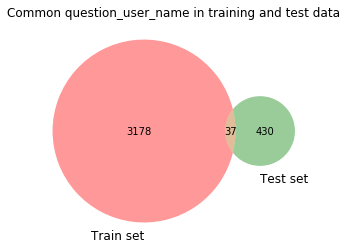

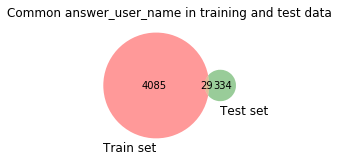

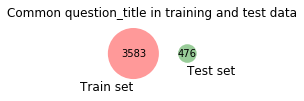

In [17]:
analysis.venn_diagrams([X_train['question_user_name'], X_test['question_user_name']], 111, 'Common question_user_name in training and test data')
analysis.venn_diagrams([X_train['answer_user_name'], X_test['answer_user_name']], 121, 'Common answer_user_name in training and test data')
analysis.venn_diagrams([X_train['question_title'], X_test['question_title']], 131, 'Common question_title in training and test data')

### 2.5. Length of contents

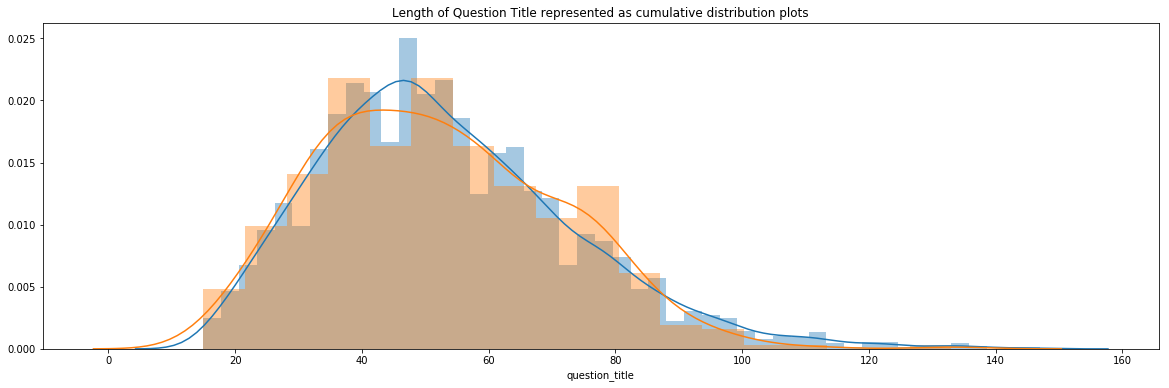

In [18]:
analysis.distribution_imposition(X_train['question_title'], X_test['question_title'], 'Length of Question Title represented as cumulative distribution plots')

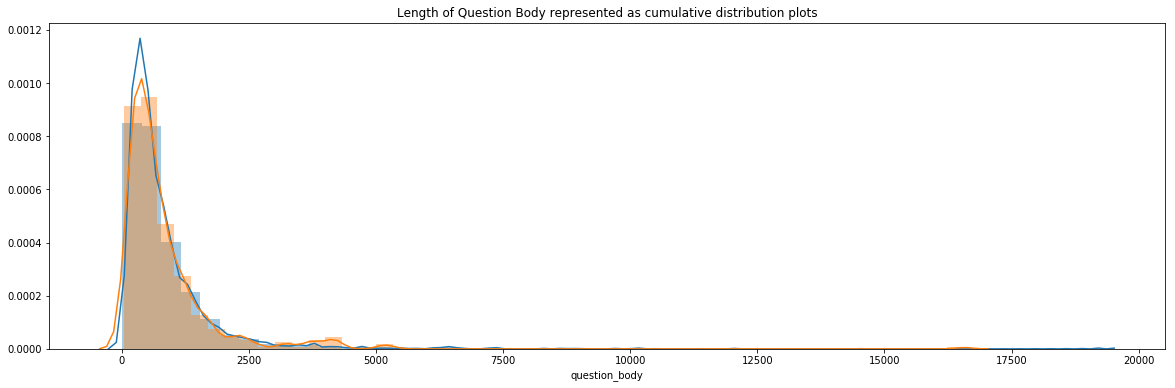

In [19]:
analysis.distribution_imposition(X_train['question_body'], X_test['question_body'], 'Length of Question Body represented as cumulative distribution plots')

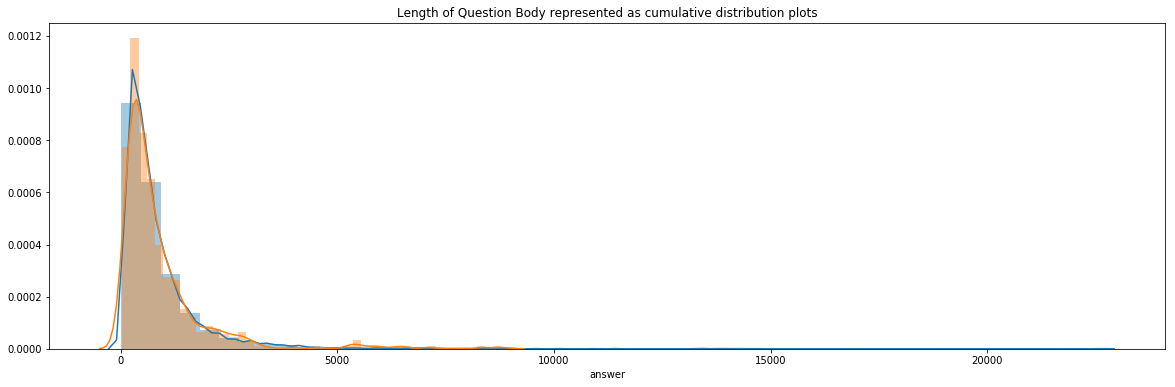

In [20]:
analysis.distribution_imposition(X_train['answer'], X_test['answer'], 'Length of Question Body represented as cumulative distribution plots')

### 2.6. Most popular questions

In [21]:
X_train.groupby('question_title').count()['qa_id'].sort_values(ascending=False).head(25)

question_title
What is the best introductory Bayesian statistics textbook?                        12
What does mathematics have to do with programming?                                 11
Important non-technical course for programmers?                                    11
How to prevent the "Too awesome to use" syndrome                                    9
Another instructor is pushing me out of the classroom right after my class ends     7
No sound in Ubuntu except at log in                                                 7
How do I deal with a slow and undedicated colleague in the team?                    7
What are the benefits of owning a physical book?                                    7
House rules to make the cloister less of a game winning tile in Carcassonne?        6
Making sure that you have comprehended a concept                                    6
hide javascript/jquery scripts from html page?                                      6
What is the best place to start Warhamm

In [22]:
X_train[X_train['question_title'] == 'What is the best introductory Bayesian statistics textbook?']

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
229,366,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"""Bayesian Core: A Practical Approach to Comput...",gappy,https://stats.stackexchange.com/users/30,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
1616,2536,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I am now reading : From Algorithm to Z-Scores:...,Fabio,https://stats.stackexchange.com/users/40316,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
1647,2591,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"My favorite is ""Bayesian Data Analysis"" by Gel...",Shane,https://stats.stackexchange.com/users/5,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
2104,3349,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I have read some parts of A First Course in Ba...,George Dontas,https://stats.stackexchange.com/users/339,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3476,5543,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"Sivia and Skilling, Data analysis: a Bayesian ...",denis,https://stats.stackexchange.com/users/557,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3762,5989,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,If I had to choose a single text for a beginne...,Jim Stone,https://stats.stackexchange.com/users/26779,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3801,6041,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,"Take a look at ""The Bayesian Choice"". It has t...",Zen,https://stats.stackexchange.com/users/9394,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
3899,6215,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I found an excellent introduction in Gelman an...,Jack Tanner,https://stats.stackexchange.com/users/8207,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
4408,7003,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,Its focus isn't strictly on Bayesian statistic...,Joe,https://stats.stackexchange.com/users/1119,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com
5239,8328,What is the best introductory Bayesian statist...,Which is the best introductory textbook for Ba...,Shane,https://stats.stackexchange.com/users/5,I read:\n\nGelman et al (2013). Bayesian Data ...,stochazesthai,https://stats.stackexchange.com/users/44171,http://stats.stackexchange.com/questions/125/w...,SCIENCE,stats.stackexchange.com


## 3. Feature Engineering

### 3.1. Data Cleaning

In [30]:
!pip install ../input/sacremoses/sacremoses-master/ 
!pip install ../input/transformers/transformers-master/

Processing /kaggle/input/sacremoses/sacremoses-master
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=882724 sha256=6887c58659ec8cd9ae717addf7e0baf69035b0eb81082a9e9f6615a7d177f7e9
  Stored in directory: /root/.cache/pip/wheels/82/48/4b/05cb49d913a40c9d76f97931cd747d72fb17a77b0f6415cdba
Successfully built sacremoses
  Found existing installation: sacremoses 0.0.35
    Uninstalling sacremoses-0.0.35:
      Successfully uninstalled sacremoses-0.0.35
Processing /kaggle/input/transformers/transformers-master
  Created wheel for transformers: filename=transformers-2.3.0-cp36-none-any.whl size=447369 sha256=23a7f5174088195cd1d72e124aecbd53837c3005ca58a3a9fe205720f7f413c8
  Stored in directory: /root/.cache/pip/wheels/ce/f3/1a/ee7248890cb4b8e8975988b1a67999e2d09ef54ce8ee815255
Successfully built transformers
  Found existing installation: transformers 2.3.0
    Uninstalling transformers-2.3.0:
      Successfully uninstalled transformers-2.3.0


In [31]:
train_features = Feature_Engineering(X_train)
test_features = Feature_Engineering(X_test)

X_train['question_title'] = train_features.flow('question_title')
X_train['question_body'] = train_features.flow('question_body')
X_train['answer'] = train_features.flow('answer')
X_test['question_title'] = test_features.flow('question_title')
X_test['question_body'] = test_features.flow('question_body')
X_test['answer'] = test_features.flow('answer')

X_train.drop(columns=['question_user_page', 'answer_user_page', 'url'], inplace=True)
X_test.drop(columns=['question_user_page', 'answer_user_page', 'url'], inplace=True)

ValueError: Can't find a vocabulary file at path '/root/.cache/torch/transformers/889369c332dd60a59ce027e6508f7bf21407a000356a73e69fd2e00973a981fb'. To load the vocabulary from a Google pretrained model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`

### 3.2. Transform frequent operations on documents

In [ ]:
X_train['question_title_tfidf_vec'] = train_features.tfidf_vec('question_title')
X_train['question_body_tfidf_vec'] = train_features.tfidf_vec('question_body')
X_train['answer_tfidf_vec'] = train_features.tfidf_vec('answer')

X_test['question_title_tfidf_vec'] = test_features.tfidf_vec('question_title')
X_test['question_body_tfidf_vec'] = test_features.tfidf_vec('question_body')
X_test['answer_tfidf_vec'] = test_features.tfidf_vec('answer')

### 3.3. Encoding categorical features

In [ ]:
# X_train['category_vec'] = list(LabelBinarizer().fit_transform(X_train['category'].values))
# X_train['question_user_name_vec'] = list(LabelBinarizer().fit_transform(X_train['question_user_name'].values))
# X_train['answer_user_name_vec'] = list(LabelBinarizer().fit_transform(X_train['answer_user_name'].values))
# X_train['host_vec'] = list(LabelBinarizer().fit_transform(X_train['host'].values))

# diff = abs(len(X_test['question_user_name'].value_counts()) - len(X_train['question_user_name'].value_counts()))
# d = np.zeros((X_test.shape[0], diff))
# a = list(LabelBinarizer().fit_transform(X_train['question_user_name'].values))
# b = list(LabelBinarizer().fit_transform(X_test['question_user_name'].values))
# a = np.array(a)
# c = np.concatenate([b, d], axis=1)
# print(np.array(a).shape)
# print(np.array(b).shape)
# print(np.array(c).shape)

X_train['category_vec'] = train_features.binarize('category', X_test)
X_test['category_vec'] = test_features.binarize('category', X_train)
X_train['question_user_name_vec'] = train_features.binarize('question_user_name', X_test)
X_train['answer_user_name_vec'] = train_features.binarize('answer_user_name', X_test)
X_train['host_vec'] = train_features.binarize('host', X_test)


X_test['question_user_name_vec'] = test_features.binarize('question_user_name', X_train)
X_test['answer_user_name_vec'] = test_features.binarize('answer_user_name', X_train)
X_test['host_vec'] = test_features.binarize('host', X_train)

In [ ]:
X_train

In [ ]:
X_test

### 3.4. Bidirectional Encoder Representations from Transformers (BERT)

In [ ]:
train_features.model_conf()
test_features.model_conf()

In [ ]:
X_train['question_title'] = train_features.bert_separators('question_title')
X_train['question_body'] = train_features.bert_separators('question_body')
X_train['answer'] = train_features.bert_separators('answer')

X_test['question_title'] = test_features.bert_separators('question_title')
X_test['question_body'] = test_features.bert_separators('question_body')
X_test['answer'] = test_features.bert_separators('answer')

In [ ]:
question_title_vectors_train = train_features.make_vectors("question_title")
question_body_vectors_train = train_features.make_vectors("question_body")
answer_vectors_train = train_features.make_vectors("answer")

question_title_vectors_test = test_features.make_vectors("question_title")
question_body_vectors_test = test_features.make_vectors("question_body")
answer_vectors_test = test_features.make_vectors("answer")

In [ ]:

X_train = np.concatenate([
                     np.vstack(X_train['category_vec']),
                     np.vstack(X_train['host_vec']),
                     np.vstack(X_train['question_user_name_vec']),
                     np.vstack(X_train['answer_user_name_vec']),
                     np.array(question_title_vectors_train)[:,0,:],
                     np.array(question_body_vectors_train)[:,0,:],
                     np.array(answer_vectors_train)[:,0,:],
                     np.vstack(X_train['question_title_tfidf_vec']),
                     np.vstack(X_train['question_body_tfidf_vec']),
                     np.vstack(X_train['answer_tfidf_vec'])
                     ], axis = 1)



In [ ]:
                     
X_test = np.concatenate([
                     np.vstack(X_test['category_vec']),
                     np.vstack(X_test['host_vec']),
                     np.vstack(X_test['question_user_name_vec']),
                     np.vstack(X_test['answer_user_name_vec']),
                     np.array(question_title_vectors_test)[:,0,:],
                     np.array(question_body_vectors_test)[:,0,:],
                     np.array(answer_vectors_test)[:,0,:],
                     np.vstack(X_test['question_title_tfidf_vec']),
                     np.vstack(X_test['question_body_tfidf_vec']),
                     np.vstack(X_test['answer_tfidf_vec'])
                     ], axis = 1)

In [ ]:
pd.DataFrame(X_train)

In [ ]:
pd.DataFrame(X_test)

In [ ]:
Y_train

## 4. Modeling and training

In [ ]:
all_predictions = []

kf = KFold(n_splits=5, random_state=42, shuffle=True)

X_test = X_test.reshape(-1, 1, X_test.shape[1])
for ind, (train, validation) in enumerate(kf.split(X_train)):
    X_train_part= X_train[train]
    Y_train_part = Y_train.iloc[train, :]
    X_validate_part = X_train[validation]
    Y_validate_part = Y_train.iloc[validation, :]
    
    X_train_part = X_train_part.reshape(-1, 1, X_train.shape[1])
    Y_train_part = np.array(Y_train_part).reshape(-1, 1, Y_train.shape[1])
    X_validate_part = X_validate_part.reshape(-1, 1, X_validate_part.shape[1])
    Y_validate_part = np.array(Y_validate_part).reshape(-1, 1, Y_validate_part.shape[1])
    
    model = Network.create_model()
    model.fit(X_train_part, Y_train_part, epochs=100, batch_size=32, validation_data=(X_validate_part, Y_validate_part), verbose=True,
        callbacks=[SpearmanCallback(validation_data=(X_validate_part, Y_validate_part), model_name=f'best_model_batch{ind}.h5')])
    all_predictions.append(model.predict(X_test))

In [ ]:
all_predictions = np.array(all_predictions)[:,:,0,:]

### 4.1. Averaging predictions

In [ ]:
final = pd.DataFrame(np.array(all_predictions)[0,:,:])
final = pd.concat([pd.DataFrame(np.array(all_predictions)[valid_pred,:,:]) for valid_pred in range(5)], axis=1)
for num in range(31):
    final[num] = final.iloc[:, [num * valid_pred for valid_pred in range(5)]].mean(axis=1)
final = final.iloc[:, :31]

### 4.2. Submiting 

In [ ]:
final.columns = sample_submission.columns

In [ ]:
final['qa_id'] = sample_submission['qa_id']

In [ ]:
final

In [ ]:
final.to_csv('submission.csv', index=False)